<a href="https://colab.research.google.com/github/JAKravitz/JPL_WQ_ML/blob/main/TrainingData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Connect to gitHub repo and add to python path


In [1]:
!git clone https://github.com/JAKravitz/JPL_WQ_ML.git

import sys
sys.path.insert(0,'/content/JPL_WQ_ML')

Cloning into 'JPL_WQ_ML'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 31 (delta 15), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (31/31), done.


# Import modules

In [2]:
import pickle
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from MLP_retrieval import MLPregressor
import matplotlib.pyplot as plt

# Connect to google drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data

Data currently stored as nested dictionaries and pandas dataframes in python a python pickle file. This post-processed data is is already resolved to different sensor resolutions which make up the 6 dataframes in the pickle file. Sensors are in number of increasing resolution: Landsat OLI, Sentinel-2 MSI, MODIS, MERIS, Sentinel-3 OLCI, HICO.

Each sensor includes a dataframe with the remote sensing reflectance (Rrs) for each band, as well as a number of paired biogeochemical info and some inherent optical properties (IOPs - absorbing and scattering in units m^-1) at 440 nm. (Full hyperspectral IOPs are in a separate dataset which I can share if we get to that point.)

In [4]:

# Retrieve data
with open('/content/drive/MyDrive/nasa_npp/RT/sensorIDX_rrs.p', 'rb') as fp:
  sensorData = pickle.load(fp)

# inspect datasets
print(f'Sensors: {sensorData.keys()}\n')

# inspect sensor data
landsat8 = sensorData['l8']
l8Bands = landsat8.filter(regex='^[0-9]')
l8Targets = landsat8.filter(regex='^[a-zA-Z]')

print('Landsat 8 OLI synthetic reflectance data:')
l8Bands.head()

Sensors: dict_keys(['s3', 's2', 'modis', 'meris', 'l8', 'hico'])

Landsat 8 OLI synthetic reflectance data:


,443,482,561,665,865
0,0.002678,0.003951,0.006962,0.007311,0.000784
1,0.001406,0.002081,0.003643,0.001926,0.000121
2,0.002194,0.004156,0.008614,0.002771,0.000142
3,0.004412,0.007036,0.012674,0.005947,0.000369
4,0.000229,0.000473,0.001568,0.001353,0.000082


# Outputs

The other columns are a mix of potential target outputs and some feature interaction which are usually in the form of some band ratios and band differences. Targets of interest include the following below. This should be enough to get us started. 
<br>
<br>**chl** = concentration of pigment chl-a (ubiquitous in all phytoplankton, main   biogeochemical indication of phyto biomass, mg/m^3) 
<br>**PC** = concentration of pigment phycocyanin (Only present in cyanobacteria, mg/m^3)
<br>**admix** = Fraction of cyanobacteria in assemblage (0-1)
<br>**dinoD** = Average diameter of the non-cyanobacteria fraction of the phyto assemblage (micrometers)
<br>**cnap** = Concentration of non-algal particles (this is minerals and detritus combined)
<br>**FQY** = Fluorescence quantum yield (probably not relevant right now, but could be interesting to look at if there is time
<br>**cy** = species of cyanobacteria used in simulation
<br>**fl_amp** = fluorescence amplitude (amplitude of the solar induced chlorophyll-a fluorescence signal, again could be interesting if time allows)
<br>**aphy440, ag440, anap440** = absorption due to phytoplankton, CDOM, and non-algal particles, respectfully, at 440 nm (sum of these equals total absorption (other than water), m^-1)
<br>**bbphy440, bbnap440** = backscattering due to phytoplankton and non-algal particles (CDOM is dissolved and thus does not scatter light, sum is total backscatter, m^-1)
<br>**apc620** = absorption due to pigment phycocyanin at 620nm (cyanos have a unique absorption feature centered at 620nm)
<br>**aphy620** = absorption due to total phytolankton at 620nm 
<br>**aphy675** = absorption due to total phytolankton at 675nm (chl-a has a unique absorption feature centered at 675nm)
<br>**pc_chla** = phycocyanin to chl-a ratio (indication of cyano dominance)
<br>**cluster** = Cluster the particular reflecance spectrum belongs to (1-13) based on a Kmeans clustering analysis (see manuscript for more details)
<br>
<br>**Must haves**:
<br> - retrieval of pigment concentrations: chl-a, PC 
<br> - retrieval of non algal particle concentration: Cnap
<br>**Nice to haves**:
<br>- retrieval of component absorption and backscattering @ 440nm
<br>- retrieval of cluster
<br>- retrieval of admix parameter (cyano fraction - but not much field validation for this) 
<br>**Super nice to have**:
<br>- retireval of hyperspectral absorption and backscattering (data located in separate dataset)


In [5]:
print('Paired biogeophysical and optical data:')
l8Targets.head()

Paired biogeophysical and optical data:


,iHy,k,chl,admix,dinoD,cnap,cdom,FQY,cy,fl_amp,...,b1,b2,b3,b4,b4/b3,b4/b2,b4/b1,b3/b2,b3/b1,b2/b1
0,42390.0,0,0.15,0.1,5.0,9.333,1.035,0.005,aph,0.001106,...,0.002678,0.003951,0.006962,0.007311,1.050139,1.850644,2.729868,1.762286,2.599531,1.475091
1,18723.0,1,0.16,0.0,6.0,1.303,0.746,0.010,nod,0.004361,...,0.001406,0.002081,0.003643,0.001926,0.528708,0.925568,1.369481,1.750622,2.590240,1.479611
2,39059.0,2,0.19,0.0,17.0,1.487,0.822,0.010,aer,0.004299,...,0.002194,0.004156,0.008614,0.002771,0.321661,0.666698,1.262735,2.072673,3.925670,1.894014
3,14425.0,3,0.21,0.0,6.0,2.754,0.506,0.010,aph,0.005239,...,0.004412,0.007036,0.012674,0.005947,0.469229,0.845218,1.347973,1.801289,2.872739,1.594824
4,22380.0,4,0.21,0.4,9.0,1.637,4.451,0.005,ana,0.001954,...,0.000229,0.000473,0.001568,0.001353,0.862963,2.861645,5.900041,3.316068,6.836954,2.061765


# Basic artifical neural network application to the data

In [6]:
# targets for retrieval - can be single or code is set up for multi-output
target = ['chl','PC','cnap','cluster']

# Information for the training
batch_info = {'sensor': 'hico',  # which sensor you will train on
              'epochs': 10,      # number of epochs
              'batch_size': 32,  # batch size
              'lrate': .0001,    # learning rate
              'split': .1,       # split for train/test
              'targets': target, # targets
              'cv': 3,           # number of how many cross-validations 
              'meta': None,      # this is for when using top-of-atmosphere data, irrelevant
              'Xpca': 10,        # number of principal components to for dimensionality reduction of input bands
              }

for key, value in batch_info.items():
    value = None if value == 'None' else value
    batch_info[key] = value

In [7]:
# instantiate the ANN class
model = MLPregressor(batch_info)

# get the X (inputs) and Y (outputs) data
# y = log transformed and standard scaled 
# y0 = raw y values
X, y, y0 = model.getXY(sensorData)

# prep the results dictionary for the various evaluation statistics  
results = model.prep_results(y)

# split for train/test
# train data is further split for cross validation information (error bars for statistics)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=batch_info['split'])
kfold = KFold(n_splits=batch_info['cv'], shuffle=True)

# run model through cross validation and output results to dictionary
count = 0
for train, test in kfold.split(X_train, y_train):
    print ('\n## FOLD = {}... ##\n'.format(count))
    model.build()
    X_tn, X_tt = X_train.iloc[train,:], X_train.iloc[test,:]
    y_tn, y_tt = y_train.iloc[train,:], y_train.iloc[test,:] 
    history = model.fit(X_tn,y_tn)
    y_ht = model.predict(X_tt)
    results = model.evaluate(y_ht,y_tt,results,'cv') 
    count = count+1

# Run and test on unseen data and output results
print ('\n## FINAL MODEL ##\n')
history2 = model.fit(X_train,y_train)
results['train_loss'].append(history2.history['loss'])
results['val_loss'].append(history2.history['val_loss'])
y_hat = model.predict(X_test)
results = model.evaluate(y_hat,y_test,results,'final') 
results = model.owt_evaluate(y_hat,y_test,results)
results['batch_info'] = batch_info



## FOLD = 0... ##

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1408      
                                                                 
 re_lu (ReLU)                (None, 128)               0         
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 re_lu_1 (ReLU)              (None, 64)                0         
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 

Text(0.5, 1.0, 'PC')

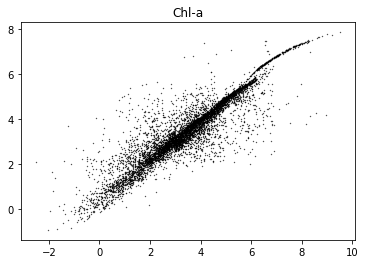

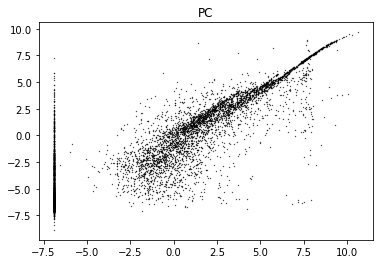

In [9]:
# plot results of final model

fig, ax = plt.subplots()
ax.scatter(results['chl']['final']['ytest'], results['chl']['final']['yhat'],s=.1,c='k')
ax.set_title('Chl-a')

fig, ax = plt.subplots()
ax.scatter(results['PC']['final']['ytest'], results['PC']['final']['yhat'],s=.1,c='k')
ax.set_title('PC')

In [10]:
results.keys()

dict_keys(['chl', 'fit_time', 'pred_time', 'train_loss', 'val_loss', 'PC', 'cnap', 'batch_info'])

In [11]:
results['chl']['owt']['Mild']

{'Bias': [0.026299881183511134],
 'MAPE': [19.343771552751928],
 'R2': [0.7559586477915872],
 'RMSE': [65.42064780197934],
 'RMSELE': [0.6146664086882241],
 'rRMSE': [174.03014648747012],
 'yhat': [0       3.733974
  1       3.297457
  5       1.931853
  8       3.715275
  11      2.449918
            ...   
  6591    3.544589
  6603    1.956423
  6604    1.481520
  6608    3.986712
  6609    2.904635
  Name: chl, Length: 1124, dtype: float64],
 'ytest': [0       3.583547
  1       3.175592
  5       1.944624
  8       3.608780
  11      1.979759
            ...   
  6591    3.406218
  6603    1.798570
  6604    1.047670
  6608    3.394206
  6609    2.596075
  Name: chl, Length: 1124, dtype: float64]}